# ADVERSARIAL EXAMPLE GENERATION

Author: Nathan Inkawhich

If you are reading this, hopefully you can appreciate how effective some machine learning models are. Research is constantly pushing ML models to be faster, more accurate, and more efficient. However, an often overlooked aspect of designing and training models is security and robustness, especially in the face of an adversary who wishes to fool the model.

This tutorial will raise your awareness to the security vulnerabilities of ML models, and will give insight into the hot topic of adversarial machine learning. You may be surprised to find that adding imperceptible perturbations to an image can cause drastically different model performance. Given that this is a tutorial, we will explore the topic via example on an image classifier. Specifically we will use one of the first and most popular attack methods, the Fast Gradient Sign Attack (FGSM), to fool an MNIST classifier.

## Threat Model

For context, there are many categories of adversarial attacks, each with a different goal and assumption of the attacker’s knowledge. However, in general the overarching goal is to add the least amount of perturbation to the input data to cause the desired misclassification. There are several kinds of assumptions of the attacker’s knowledge, two of which are: **white-box** and **black-box**. A *white-box* attack assumes the attacker has full knowledge and access to the model, including architecture, inputs, outputs, and weights. A *black-box* attack assumes the attacker only has access to the inputs and outputs of the model, and knows nothing about the underlying architecture or weights. There are also several types of goals, including **misclassification** and **source/target misclassification**. A goal of misclassification means the adversary only wants the output classification to be wrong but does not care what the new classification is. A source/target misclassification means the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.

In this case, the FGSM attack is a *white-box* attack with the goal of *misclassification*. With this background information, we can now discuss the attack in detail.

## Fast Gradient Sign Attack

One of the first and most popular adversarial attacks to date is referred to as the *Fast Gradient Sign Attack (FGSM)* and is described by Goodfellow et. al. in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). The attack is remarkably powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn, gradients. The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data to maximize the loss based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

Before we jump into the code, let’s look at the famous [FGSM](https://arxiv.org/abs/1412.6572) panda example and extract some notation.

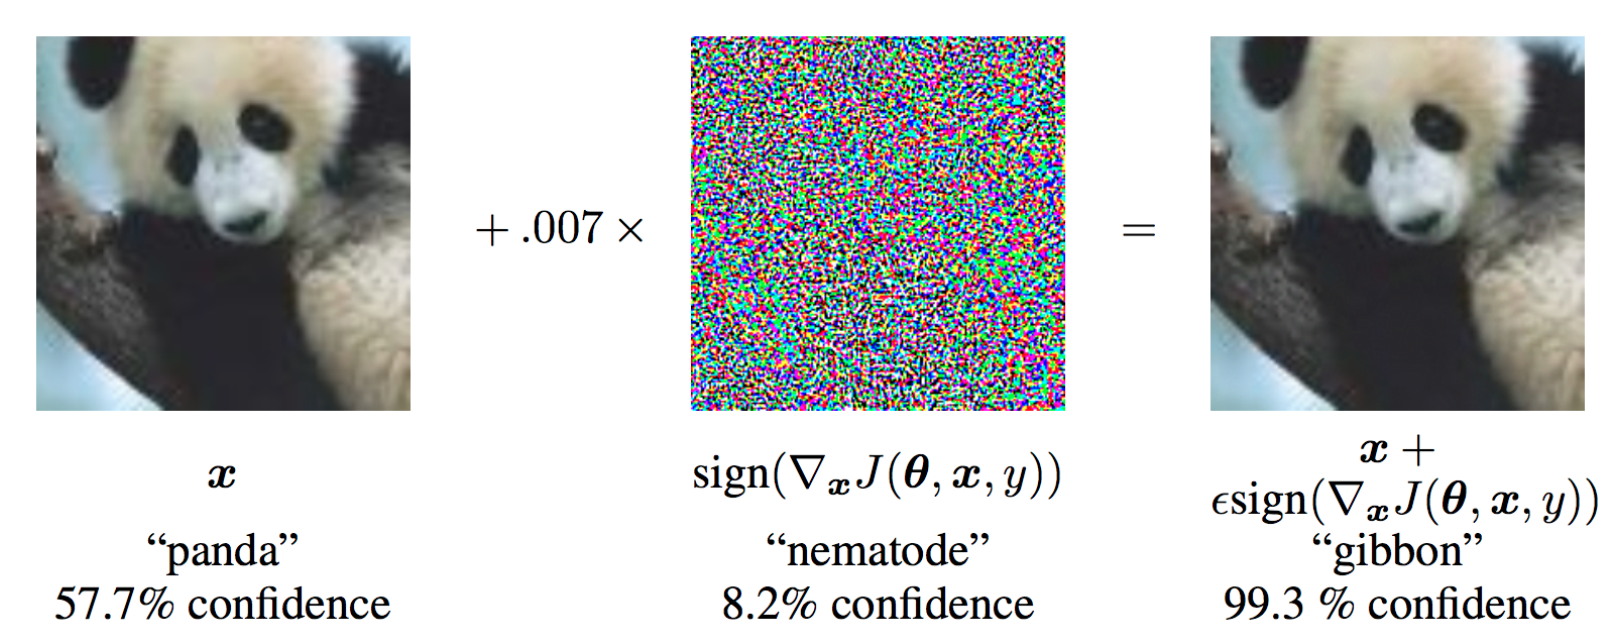

From the figure, $\textbf{x}$ is the original input image correctly classified as a “panda”, $y$ is the ground truth label for $\textbf{x}$, $θ$ represents the model parameters, and $J(θ,\textbf{x},y)$ is the loss that is used to train the network. The attack backpropagates the gradient back to the input data to calculate $∇_{x}J(θ,\textbf{x},y)$. Then, it adjusts the input data by a small step ($ϵ$ or 0.007 in the picture) in the direction (i.e. $sign(∇_{x}J(θ,\textbf{x},y))$) that will maximize the loss. The resulting perturbed image, $x′$, is then misclassified by the target network as a “gibbon” when it is still clearly a “panda”.

Hopefully now the motivation for this tutorial is clear, so lets jump into the implementation.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Implementation

In this section, we will discuss the input parameters for the tutorial, define the model under attack, then code the attack and run some tests.

### Inputs

There are only three inputs for this tutorial, and are defined as follows:

* **epsilons** - List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is \[0,1\], no epsilon value should exceed 1.
* **pretrained_model** - path to the pretrained MNIST model which was trained with [pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist). For simplicity, download the pretrained model [here](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing).
* **use_cuda** - boolean flag to use CUDA if desired and available. Note, a GPU with CUDA is not critical for this tutorial as a CPU will not take much time.

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/mnist_cnn.pt"
use_cuda=True

### Model Under Attack

As mentioned, the model under attack is the same MNIST model from [pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist). You may train and save your own MNIST model or you can download and use the provided model. The *Net* definition and test dataloader here have been copied from the MNIST example. The purpose of this section is to define the model and dataloader, then initialize the model and load the pretrained weights.

In [3]:
%%bash
python pretrained_minst.py --save-model

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333409
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.268057
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.859085
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.609946
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.394730
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.440521
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.293486
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.187813
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.438220
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.294567
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.355385
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.301056
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.382806
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.251696
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.321020
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.072140
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.082358
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.191155
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.310888
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.106632
Train Epoch: 1 [12800/60000 (

In [6]:
# LeNet Model definition
class Net(nn.Module):
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 64*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### FGSM Attack

Now, we can define the function that creates the adversarial examples by perturbing the original inputs. The ``fgsm_attack`` function takes three inputs, *image* is the original clean image $(x)$, $epsilon$ is the pixel-wise perturbation amount $(ϵ)$, and $data_grad$ is gradient of the loss w.r.t the input image $(∇_{x}J(θ,\textbf{x},y))$. The function then creates perturbed image as

<center>$perturbed\_image = image + epsilon ∗ sign(data_grad) = x + ϵ ∗ sign(∇_{x}J(θ,\textbf{x},y))$</center>

Finally, in order to maintain the original range of the data, the perturbed image is clipped to range \[0,1\].

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image